# Week 2 - Diagnostic and Descriptive Analysis

This notebook carries out the following steps (except those in parantheses for you to fill in)
1. Read the pickle file
2. Add derived features of the returns on each loan
3. Visualize variables incl. returns
4. Explore returns by grade
5. Create multi-variable summaries
6. (Run K-means on a relevant subset of the columns)
7. (Run PCA on a relevant subset of the columns)
8. Save new pickle with the new return columns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn as sns
import time
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

## Step 1 - Read pickle file from Week 1

In [ ]:
path_to_data = "/content/drive/My Drive/BVIA Group 4/Pickle/" # Change this if NOT running in Google Colab

pickle_data = path_to_data+"201516_w2.pickle" #change the name of the pickle file here 

In [ ]:
### Read the data and features from the pickle
final_data, discrete_features, continuous_features = pickle.load( open(pickle_data, "rb" ) )
#final_data, discrete_features, continuous_features = pickle.load( open( "./PickleData/201213clean_data.pickle", "rb" ) )

Notes about the pickle file ingested:
1. Log-transformed columns: annual_inc, revol_bal , open_acc, and total_pymn
2. Append  "_orig" at the end of the above log-trasnformed column names to retrieve the original value


In [ ]:
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_amnt_orig,funded_amnt_orig,term_orig,int_rate_orig,installment_orig,grade_orig,emp_length_orig,home_ownership_orig,annual_inc_orig,verification_status_orig,issue_d_orig,loan_status_orig,purpose_orig,dti_orig,delinq_2yrs_orig,earliest_cr_line_orig,open_acc_orig,pub_rec_orig,fico_range_high_orig,fico_range_low_orig,revol_bal_orig,revol_util_orig,total_pymnt_orig,last_pymnt_d_orig,recoveries_orig
0,73438990,12500.0,12500.0,60 months,7.39,249.83,A,10+ years,RENT,4.929424,Not Verified,2016-03-01,Charged Off,credit_card,19.60,1.0,2001-10-01,1.301030,0.0,699.0,695.0,3.728110,10.5,3.915670,2019-01-01,0.00,12500.0,12500.0,60 months,7.39,249.83,A,10+ years,RENT,85000.0,Not Verified,2016-03-01,Charged Off,credit_card,19.60,1.0,2001-10-01,19.0,0.0,699.0,695.0,5346.0,10.5,8234.130000,2019-01-01,0.00
1,74694337,40000.0,40000.0,60 months,7.89,808.96,A,< 1 year,MORTGAGE,4.905801,Verified,2016-03-01,Fully Paid,home_improvement,3.74,0.0,1992-11-01,0.903090,0.0,714.0,710.0,2.618048,2.5,4.683819,2020-07-01,0.00,40000.0,40000.0,60 months,7.89,808.96,A,< 1 year,MORTGAGE,80500.0,Verified,2016-03-01,Fully Paid,home_improvement,3.74,0.0,1992-11-01,7.0,0.0,714.0,710.0,414.0,2.5,48284.801138,2020-07-01,0.00
2,74826201,7200.0,7200.0,36 months,5.32,216.83,A,10+ years,MORTGAGE,4.690205,Source Verified,2016-03-01,Fully Paid,debt_consolidation,19.05,0.0,2001-12-01,1.079181,0.0,754.0,750.0,3.968950,18.4,3.858802,2016-04-01,0.00,7200.0,7200.0,36 months,5.32,216.83,A,10+ years,MORTGAGE,49000.0,Source Verified,2016-03-01,Fully Paid,debt_consolidation,19.05,0.0,2001-12-01,11.0,0.0,754.0,750.0,9309.0,18.4,7223.410000,2016-04-01,0.00
3,74884818,32000.0,32000.0,36 months,6.97,987.63,A,10+ years,OWN,5.193127,Verified,2016-03-01,Fully Paid,home_improvement,5.25,0.0,1983-07-01,0.778151,0.0,699.0,695.0,3.557748,23.6,4.548247,2018-07-01,0.00,32000.0,32000.0,36 months,6.97,987.63,A,10+ years,OWN,156000.0,Verified,2016-03-01,Fully Paid,home_improvement,5.25,0.0,1983-07-01,5.0,0.0,699.0,695.0,3611.0,23.6,35337.421039,2018-07-01,0.00
4,75174813,16000.0,16000.0,36 months,12.99,539.03,C,< 1 year,RENT,4.698979,Not Verified,2016-03-01,Charged Off,debt_consolidation,38.32,0.0,2000-08-01,1.113943,0.0,679.0,675.0,3.902927,51.6,3.772115,2016-12-01,1627.03,16000.0,16000.0,36 months,12.99,539.03,C,< 1 year,RENT,50000.0,Not Verified,2016-03-01,Charged Off,debt_consolidation,38.32,0.0,2000-08-01,12.0,0.0,679.0,675.0,7996.0,51.6,5916.180000,2016-12-01,1627.03


In [ ]:
final_data.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,loan_amnt_orig,funded_amnt_orig,int_rate_orig,installment_orig,annual_inc_orig,dti_orig,delinq_2yrs_orig,open_acc_orig,pub_rec_orig,fico_range_high_orig,fico_range_low_orig,revol_bal_orig,revol_util_orig,total_pymnt_orig,recoveries_orig
count,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000,814483.000000
mean,14723.197998,14723.175898,12.724783,440.774327,4.821001,18.882670,0.352690,1.070626,0.247090,698.422369,694.422222,4.016131,51.946214,4.081210,298.240229,14723.197998,14723.175898,12.724783,440.774327,77077.194267,18.882670,0.352690,11.886192,0.247090,698.422369,694.422222,16858.959427,51.946214,15669.889950,298.240229
std,8756.622219,8756.622642,4.621573,260.644740,0.233419,8.647241,0.937303,0.186383,0.657224,30.846458,30.845742,0.498818,24.069956,0.342380,1147.304827,8756.622219,8756.622642,4.621573,260.644740,51041.099713,8.647241,0.937303,5.684731,0.657224,30.846458,30.845742,21252.690733,24.069956,10637.392847,1147.304827
min,1000.000000,1000.000000,5.320000,14.010000,3.477266,0.000000,0.000000,0.301030,0.000000,664.000000,660.000000,0.000000,0.000000,1.549126,0.000000,1000.000000,1000.000000,5.320000,14.010000,3000.000000,0.000000,0.000000,1.000000,0.000000,664.000000,660.000000,0.000000,0.000000,34.410000,0.000000
25%,8000.000000,8000.000000,9.170000,251.580000,4.672107,12.380000,0.000000,0.954243,0.000000,674.000000,670.000000,3.787602,33.900000,3.865171,0.000000,8000.000000,8000.000000,9.170000,251.580000,47000.000000,12.380000,0.000000,8.000000,0.000000,674.000000,670.000000,6131.000000,33.900000,7330.135000,0.000000
50%,12600.000000,12600.000000,12.290000,377.040000,4.812920,18.330000,0.000000,1.079181,0.000000,689.000000,685.000000,4.056791,52.000000,4.114000,0.000000,12600.000000,12600.000000,12.290000,377.040000,65000.000000,18.330000,0.000000,11.000000,0.000000,689.000000,685.000000,11396.000000,52.000000,13000.707804,0.000000
75%,20000.000000,20000.000000,15.410000,584.230000,4.965677,25.020000,0.000000,1.204120,0.000000,714.000000,710.000000,4.309194,70.300000,4.338509,0.000000,20000.000000,20000.000000,15.410000,584.230000,92400.000000,25.020000,0.000000,15.000000,0.000000,714.000000,710.000000,20378.500000,70.300000,21801.612242,0.000000
max,40000.000000,40000.000000,30.990000,1584.900000,5.995636,49.980000,39.000000,1.959041,49.000000,850.000000,845.000000,5.602043,109.900000,4.832974,37153.460000,40000.000000,40000.000000,30.990000,1584.900000,990000.000000,49.980000,39.000000,90.000000,49.000000,850.000000,845.000000,399983.000000,109.900000,68071.794585,37153.460000


In [ ]:
final_data.isnull().sum()

id                              0
loan_amnt                       0
funded_amnt                     0
term                            0
int_rate                        0
installment                     0
grade                           0
emp_length                  49855
home_ownership                  0
annual_inc                      0
verification_status             0
issue_d                         0
loan_status                     0
purpose                         0
dti                             0
delinq_2yrs                     0
earliest_cr_line                0
open_acc                        0
pub_rec                         0
fico_range_high                 0
fico_range_low                  0
revol_bal                       0
revol_util                      0
total_pymnt                     0
last_pymnt_d                    0
recoveries                      0
loan_amnt_orig                  0
funded_amnt_orig                0
term_orig                       0
int_rate_orig 

## Step 2 - Calculate returns for each loan

In [ ]:
### Define the names of the four returns we'll be calculating

ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc", "ret_Hybrid"]

In [ ]:
## Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 3638 rows


#### Return Method 1 (pessimistic)

In [ ]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (method 1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int)
final_data['ret_PESS'] = ( (final_data.total_pymnt_orig - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['term_num'])

#### Return Method 2 (optimistic)

In [ ]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 1 to compute the return

final_data['ret_OPT'] = ( (final_data.total_pymnt_orig - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['loan_length'])
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.ret_PESS[final_data.ret_OPT < 0]

#### Return Method 3 (re-investment in fixed time horizon)

In [ ]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt_orig - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTa'] = ret_method_3(5*12, 0.001)
final_data['ret_INTb'] = ret_method_3(5*12, 0.0025)
final_data['ret_INTc'] = ret_method_3(5*12, 0.005)

#### Return Method 4 (Hybrid)

In [ ]:
def return_method_3_mod(row,T,i):
  #Similar to return method 3 calculation above, but modified to apply at row level
  actual_installment = (row.total_pymnt_orig - row.recoveries) / row['loan_length']
  cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, row.loan_length)) / ( 1 - (1 + i) )
  cash_by_end_of_loan = cash_by_end_of_loan + row.recoveries
  remaining_months = T - row['loan_length']
  final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)
  return( (12/T) * ( ( final_return - row['funded_amnt'] ) / row['funded_amnt'] ) )

def return_method_hybrid(row):
  #if loan is paid to term (m == T, i (monthly) = 5% / 12)
  if row['loan_length'] == row['term_num']:
    return return_method_3_mod(row,60,0.05/12)   
  #if loan is repaid early (m < 20% T and loan status == 'Fully Paid')
  elif row['loan_length'] < 0.2 * row['term_num'] and row['loan_status'] == 'Fully Paid':
    return ( (row.total_pymnt_orig - row.funded_amnt)
                                            / row.funded_amnt ) * (12 / row['loan_length'])
  #if loan is default early (m < 20% T and loan status != 'Fully Paid')
  elif row['loan_length'] < 0.2 * row['term_num'] and row['loan_status'] != 'Fully Paid':
    return return_method_3_mod(row,60,0.025/12)
  #if loan is default close to term (m >= 20% T and loan status != 'Fully Paid')
  else:
    return return_method_3_mod(row,60,0.05/12)

In [ ]:
final_data["ret_Hybrid"] = final_data.apply(lambda row: return_method_hybrid(row),axis=1)

In [ ]:
# Check if logic miss any values
np.where(pd.isna(final_data['ret_Hybrid']))

(array([], dtype=int64),)

In [ ]:
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_amnt_orig,funded_amnt_orig,term_orig,int_rate_orig,installment_orig,grade_orig,emp_length_orig,home_ownership_orig,annual_inc_orig,verification_status_orig,issue_d_orig,loan_status_orig,purpose_orig,dti_orig,delinq_2yrs_orig,earliest_cr_line_orig,open_acc_orig,pub_rec_orig,fico_range_high_orig,fico_range_low_orig,revol_bal_orig,revol_util_orig,total_pymnt_orig,last_pymnt_d_orig,recoveries_orig,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,ret_Hybrid
0,73438990,12500.0,12500.0,60 months,7.39,249.83,A,10+ years,RENT,4.929424,Not Verified,2016-03-01,Charged Off,credit_card,19.60,1.0,2001-10-01,1.301030,0.0,699.0,695.0,3.728110,10.5,3.915670,2019-01-01,0.00,12500.0,12500.0,60 months,7.39,249.83,A,10+ years,RENT,85000.0,Not Verified,2016-03-01,Charged Off,credit_card,19.60,1.0,2001-10-01,19.0,0.0,699.0,695.0,5346.0,10.5,8234.130000,2019-01-01,0.00,34.037660,60,-0.068254,-0.068254,-0.062533,-0.053467,-0.036967,-0.042670
1,74694337,40000.0,40000.0,60 months,7.89,808.96,A,< 1 year,MORTGAGE,4.905801,Verified,2016-03-01,Fully Paid,home_improvement,3.74,0.0,1992-11-01,0.903090,0.0,714.0,710.0,2.618048,2.5,4.683819,2020-07-01,0.00,40000.0,40000.0,60 months,7.89,808.96,A,< 1 year,MORTGAGE,80500.0,Verified,2016-03-01,Fully Paid,home_improvement,3.74,0.0,1992-11-01,7.0,0.0,714.0,710.0,414.0,2.5,48284.801138,2020-07-01,0.00,52.009282,60,0.041424,0.047788,0.049671,0.062668,0.086121,0.078043
2,74826201,7200.0,7200.0,36 months,5.32,216.83,A,10+ years,MORTGAGE,4.690205,Source Verified,2016-03-01,Fully Paid,debt_consolidation,19.05,0.0,2001-12-01,1.079181,0.0,754.0,750.0,3.968950,18.4,3.858802,2016-04-01,0.00,7200.0,7200.0,36 months,5.32,216.83,A,10+ years,MORTGAGE,49000.0,Source Verified,2016-03-01,Fully Paid,debt_consolidation,19.05,0.0,2001-12-01,11.0,0.0,754.0,750.0,9309.0,18.4,7223.410000,2016-04-01,0.00,1.018501,36,0.001084,0.038308,0.012837,0.032492,0.069288,0.038308
3,74884818,32000.0,32000.0,36 months,6.97,987.63,A,10+ years,OWN,5.193127,Verified,2016-03-01,Fully Paid,home_improvement,5.25,0.0,1983-07-01,0.778151,0.0,699.0,695.0,3.557748,23.6,4.548247,2018-07-01,0.00,32000.0,32000.0,36 months,6.97,987.63,A,10+ years,OWN,156000.0,Verified,2016-03-01,Fully Paid,home_improvement,5.25,0.0,1983-07-01,5.0,0.0,699.0,695.0,3611.0,23.6,35337.421039,2018-07-01,0.00,27.992361,36,0.034765,0.044710,0.031143,0.047484,0.077352,0.067012
4,75174813,16000.0,16000.0,36 months,12.99,539.03,C,< 1 year,RENT,4.698979,Not Verified,2016-03-01,Charged Off,debt_consolidation,38.32,0.0,2000-08-01,1.113943,0.0,679.0,675.0,3.902927,51.6,3.772115,2016-12-01,1627.03,16000.0,16000.0,36 months,12.99,539.03,C,< 1 year,RENT,50000.0,Not Verified,2016-03-01,Charged Off,debt_consolidation,38.32,0.0,2000-08-01,12.0,0.0,679.0,675.0,7996.0,51.6,5916.180000,2016-12-01,1627.03,9.035093,36,-0.210080,-0.210080,-0.121956,-0.115397,-0.103240,-0.107472


## Step 3 - Visualize the variables

In [ ]:
# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries', 
                                    'ret_OPT',	'ret_PESS',	'ret_INTa',	'ret_INTb',	'ret_INTc',	'ret_Hybrid']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker and histogram plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # Float columns
    for i in float_cols + perc_cols:
        fig, axs = plt.subplots(1, 2, tight_layout=True)

        sns.boxplot(final_data[i], ax = axs[0])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = round(min(final_data[i]),2)
        axs[0].text(smallest_val, -0.3, round(highest_vals[0],2))
        axs[0].text(smallest_val, -0.2, round(highest_vals[1],2))
        axs[0].text(smallest_val, -0.1, round(highest_vals[2],2))

        #Draw the histogram
        axs[1] = plt.hist(final_data[i],50)
        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



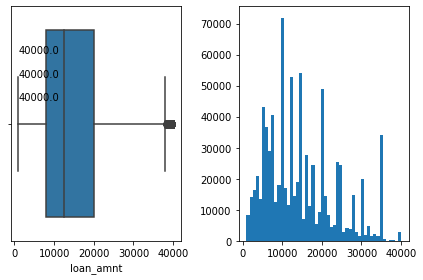

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



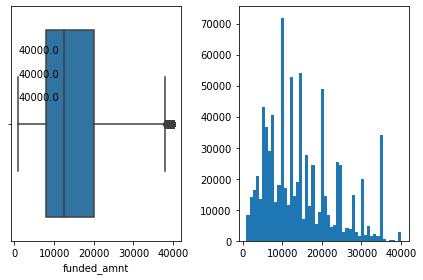

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



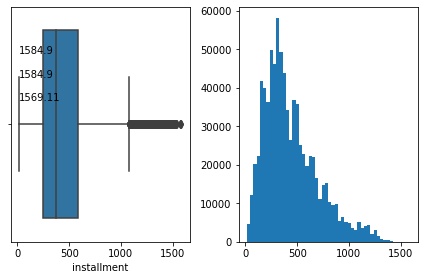

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



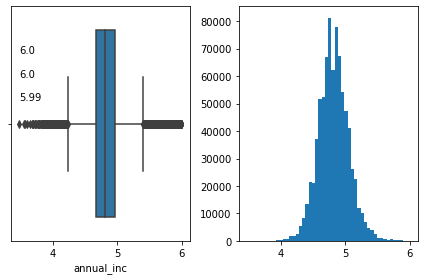

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



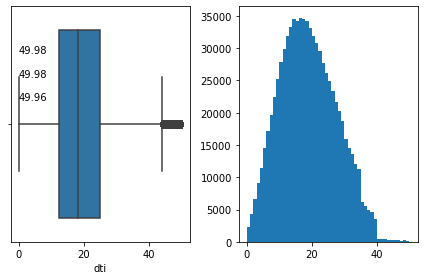

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



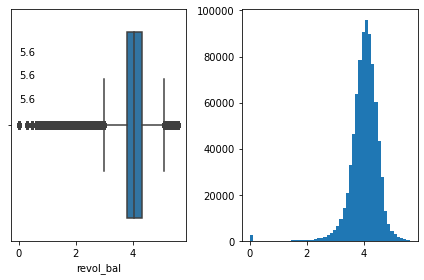

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



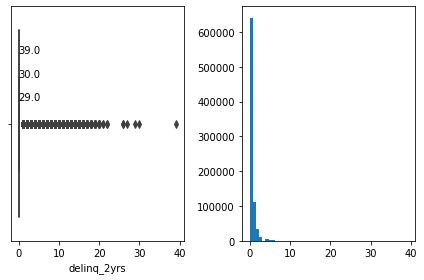

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



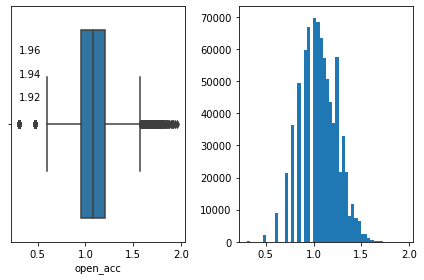

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



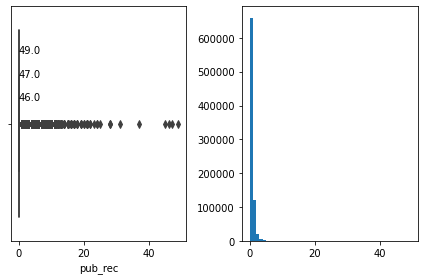

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



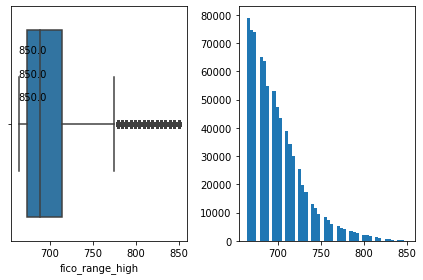

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



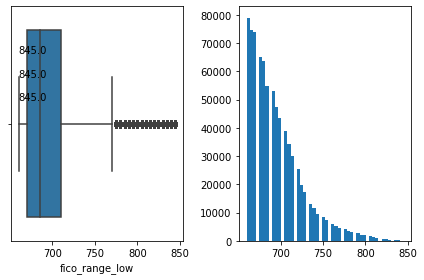

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



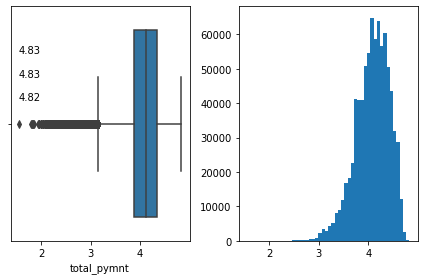

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



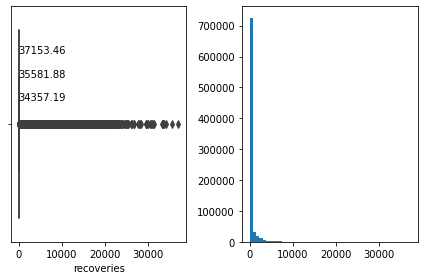

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



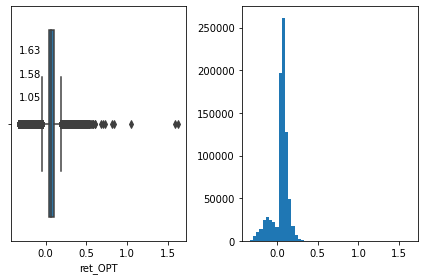

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



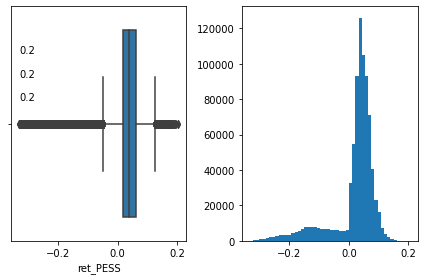

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



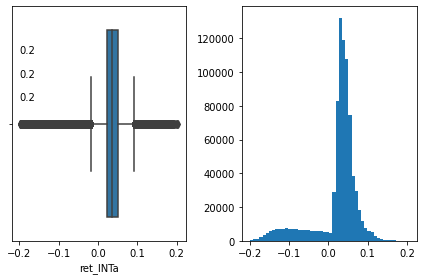

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



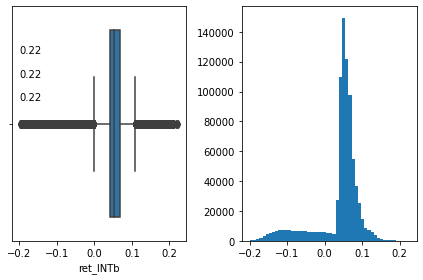

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



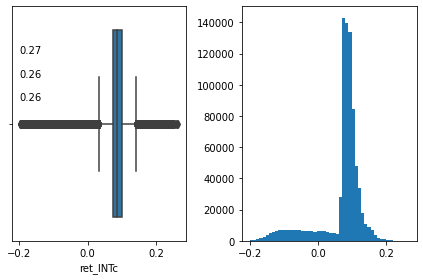

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



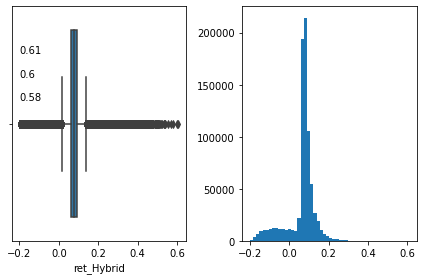

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



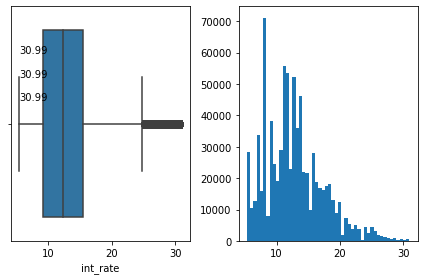

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



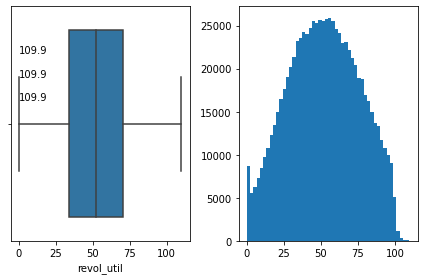

term
2 distinct values
 36 months    602040
 60 months    208805
Name: term, dtype: int64


grade
7 distinct values
B    241685
C    236004
A    141730
D    113454
E     56028
F     17613
G      4331
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    274185
2 years       73409
3 years       64885
< 1 year      63234
1 year        54017
5 years       48806
4 years       47834
8 years       38238
6 years       33685
9 years       31913
7 years       31002
Name: emp_length, dtype: int64


home_ownership
4 distinct values
MORTGAGE    394517
RENT        322668
OWN          93556
ANY            104
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Source Verified    349513
Verified           236492
Not Verified       224840
Name: verification_status, dtype: int64


loan_status
3 distinct values
Fully Paid     652384
Charged Off    158423
Default            38
Name: loan_status, dtype: int64


purpose
14 distinct values
debt_consolidation    472473

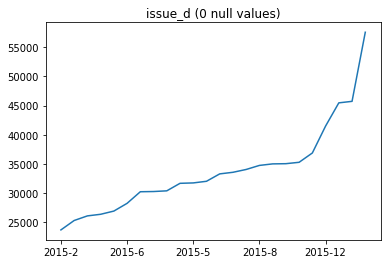

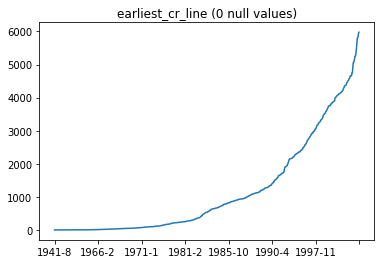

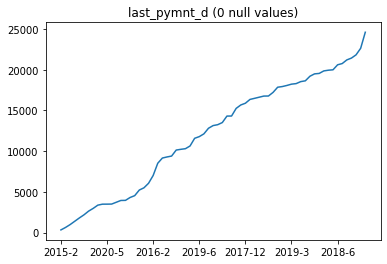

In [ ]:
visualize_columns()

## Step 4 - Explore returns by loan grade

In [ ]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 )
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)*100 )
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)*100 )
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)*100 )
ret_by_grade_INTc = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTc)*100 )
ret_by_grade_Hybrid = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_Hybrid)*100 )
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))

combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
combined['return_INTc'] = ret_by_grade_INTc
combined['return_Hybrid'] = ret_by_grade_Hybrid

combined

,grade,default,int_rate,return_OPT,return_PESS,return_INTa,return_INTb,return_INTc,return_Hybrid
A,17.479296,5.727087,6.908802,3.639489,2.174113,2.339542,3.942957,6.881712,5.902201
B,29.806560,12.945363,10.150326,4.660590,2.337938,2.533941,4.147305,7.105157,6.344516
C,29.105933,21.720395,13.545406,5.363655,2.043611,2.419251,4.026174,6.973582,6.555440
D,13.992070,30.807199,17.439422,5.953593,1.624154,2.150933,3.742521,6.663261,6.717656
E,6.909829,39.266081,20.557436,6.367694,0.942167,1.729026,3.280157,6.127183,6.741312
F,2.172178,48.498268,24.649723,6.311307,-0.151237,0.738194,2.243834,5.010688,6.323004
G,0.534134,53.151697,27.848418,6.521795,-0.852385,0.131578,1.619011,4.355386,6.275426


## Step 5 - Add multi-variable summaries, e.g. 2-vars at a time
You can start with the plot below and expand the summaries based on any interesting patterns you observe.

Observations:
1. Clearly higher the loan grade, higher the interest rate and default rate. 

2. Default rate has a high positive correlation with the optimistic return value, while having a highly negative correlation with the pessimistic, and hybrid return values. So, the user may want to adopt hybrid or pessimsitic return approach if they are  predominantly investing in loan grades A, B, or C ( that are likely to default less). On the other hand, if the investor wants to invest more in riskier loan grades such as D, E, F, or G, they may want to adopt the pessimistic or hybrid return approach. 

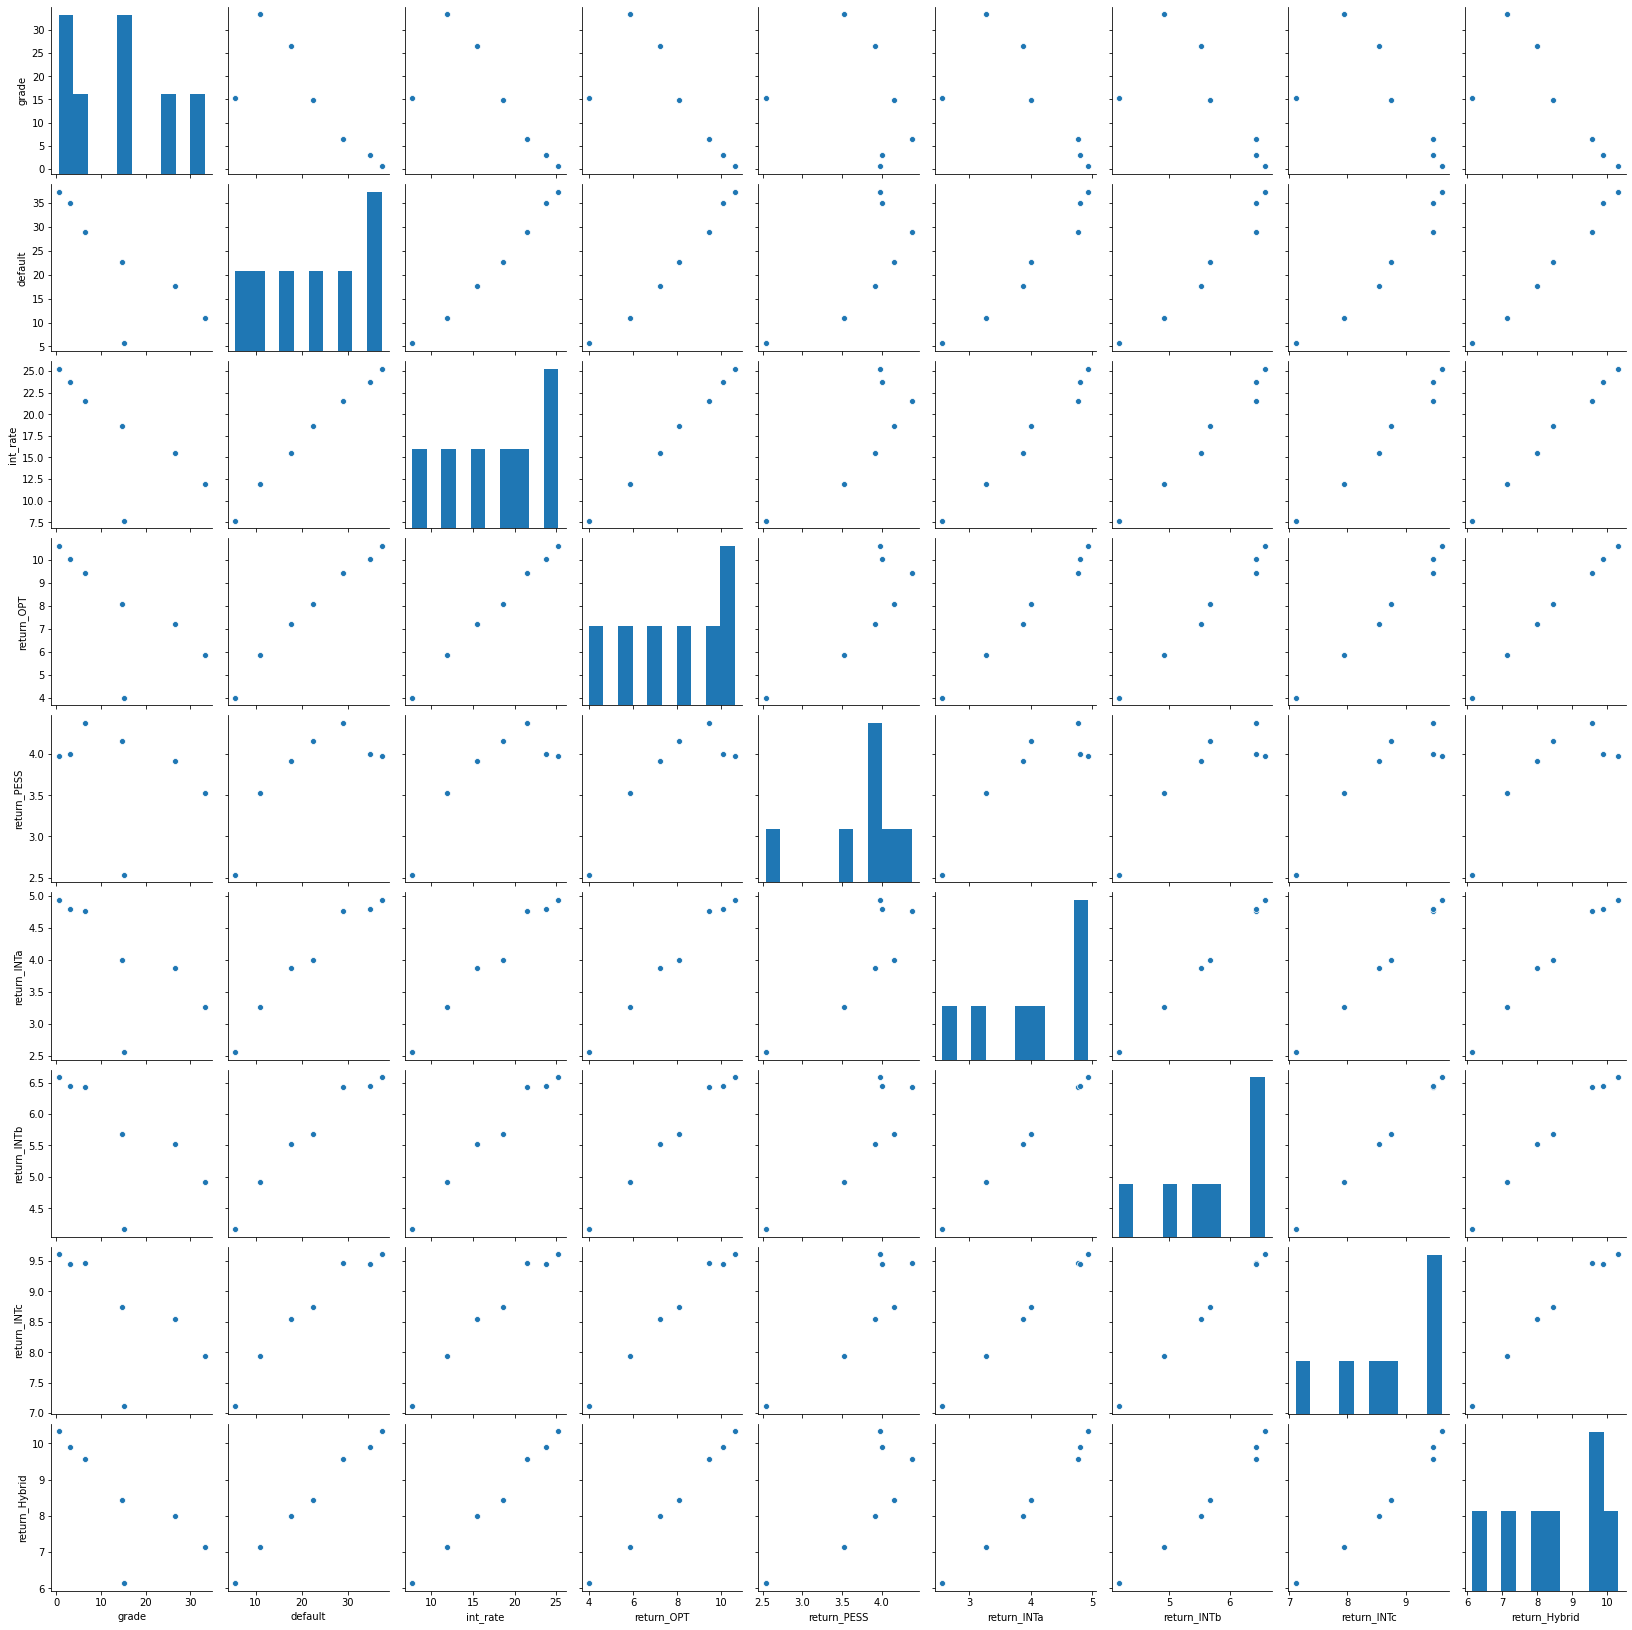

In [ ]:
sns.pairplot(combined)

Show correlation matrix.  

In [ ]:
drop_cols = [c for c in final_data.columns if 'orig' in c]
correl_df = final_data[sorted(set(final_data.columns) - set(drop_cols))]
correl_df.set_index('id', inplace=True)

#Calculate span of earliest credit line at the time the loan was issued
correl_df['credit_span'] = (correl_df.issue_d - correl_df.earliest_cr_line) / np.timedelta64(1, 'D')

#dtrop date columns
correl_df.drop(columns = date_cols, inplace=True)

correl_df.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,annual_inc,delinq_2yrs,dti,emp_length,fico_range_high,fico_range_low,funded_amnt,grade,home_ownership,installment,int_rate,loan_amnt,loan_length,loan_status,open_acc,pub_rec,purpose,recoveries,ret_Hybrid,ret_INTa,ret_INTb,ret_INTc,ret_OPT,ret_PESS,revol_bal,revol_util,term,term_num,total_pymnt,verification_status,credit_span
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10148122,4.984532,0.0,12.61,3 years,709.0,705.0,12000.0,A,MORTGAGE,373.94,7.62,12000.0,29.996509,Fully Paid,1.255273,0.0,debt_consolidation,0.0,0.068854,0.033457,0.049593,0.079043,0.046590,0.038821,4.122183,55.7,36 months,36,4.127057,Not Verified,3744.0
10149342,4.740371,0.0,22.87,10+ years,734.0,730.0,27050.0,B,OWN,885.46,10.99,27050.0,30.982156,Fully Paid,1.176091,0.0,debt_consolidation,0.0,0.082106,0.045336,0.062103,0.092684,0.067334,0.057949,4.563944,61.2,36 months,36,4.501792,Verified,9923.0
10129454,4.778158,0.0,4.62,4 years,724.0,720.0,12000.0,B,RENT,392.81,10.99,12000.0,27.992361,Fully Paid,1.204120,0.0,debt_consolidation,0.0,0.081864,0.044000,0.061249,0.092779,0.071041,0.055239,3.853577,24.0,36 months,36,4.145806,Not Verified,1461.0
10149488,4.597706,0.0,2.49,2 years,759.0,755.0,4800.0,B,MORTGAGE,157.13,10.99,4800.0,9.002238,Fully Paid,0.602060,0.0,home_improvement,0.0,0.070129,0.027041,0.046535,0.082746,0.099286,0.024828,3.616686,16.1,36 months,36,3.712525,Source Verified,6697.0
10129477,4.944488,1.0,10.02,4 years,674.0,670.0,14000.0,B,RENT,470.71,12.85,14000.0,37.027454,Fully Paid,0.845098,1.0,debt_consolidation,0.0,0.087338,0.052213,0.068257,0.097404,0.068181,0.070127,3.566673,81.9,36 months,36,4.229075,Not Verified,9314.0


Create heatmap of the correlation matrix


Observations:

1. Total payment has a very high positive correlation with funded_amnt, installment, and int_rate. It also has a medium positive correlation with annual_income and the various return rates. 
2. Fico scores have a medium negative correlation with int_rate and revol_util. 
3. Funded_amt is the same as the loan_amt with a '1' correlation. Both of them has a very high positive correlation with installment. 
4. Interestingly the credit span, which is the time since the earliest credit line date is not correlated to FICO Score.

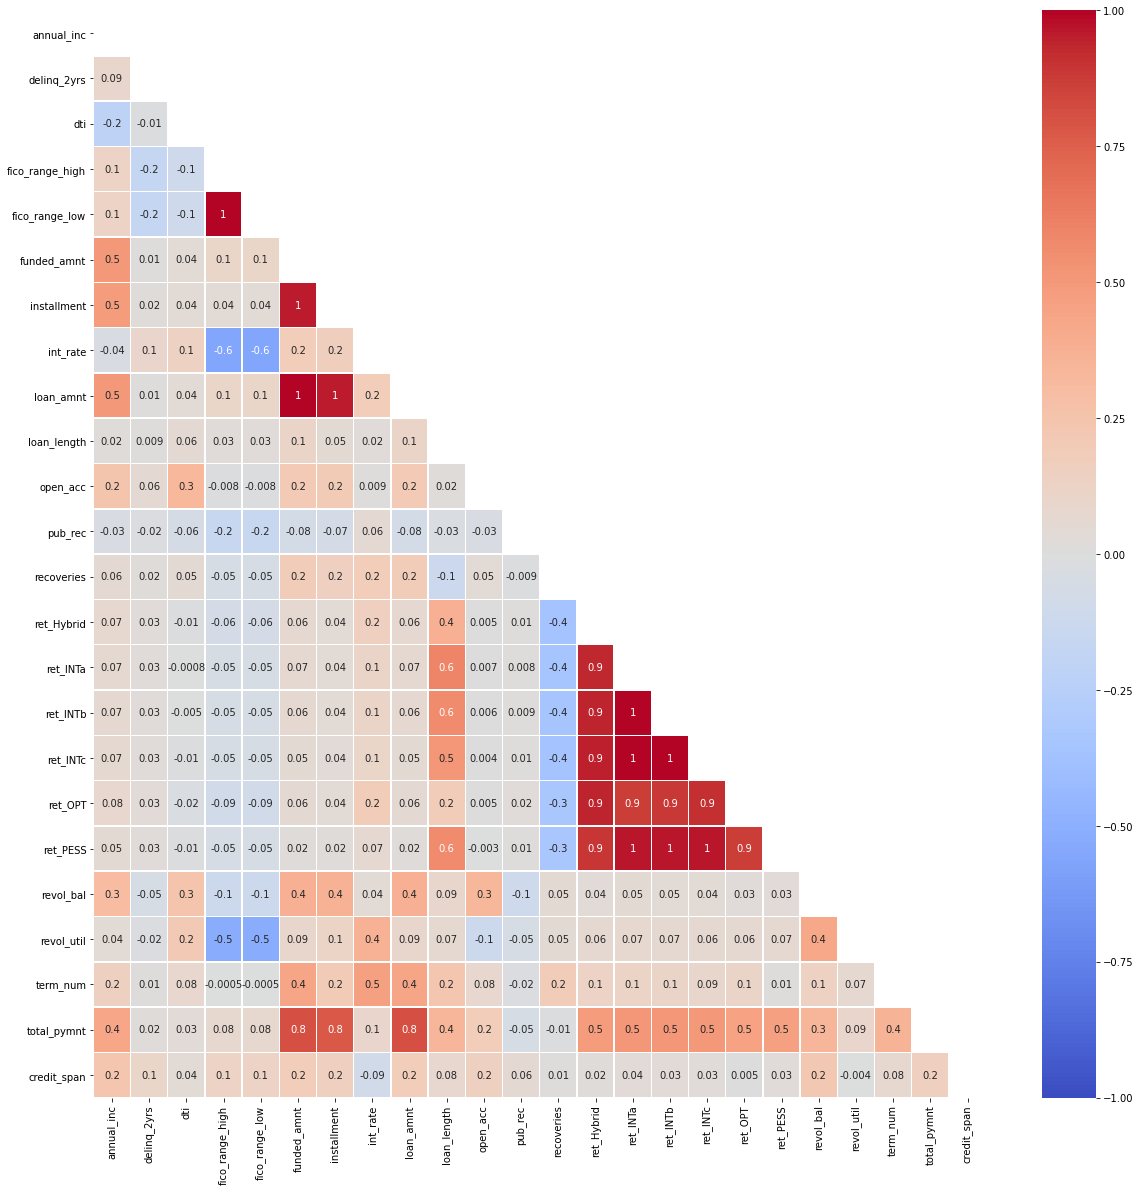

In [ ]:
fig, axs = plt.subplots(1, 1,figsize = (20, 20))
mask = np.zeros_like(correl_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correl_df.corr(), vmin=-1, vmax=1, center= 0, annot = True, fmt = '.1g', cmap= 'coolwarm', linewidths=.5, ax = axs, mask=mask)


Convert categorical variables to dummies and store it in another dataframe

In [ ]:
correl_df_cat = pd.get_dummies(correl_df)
correl_df_cat.head()

,annual_inc,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,installment,int_rate,loan_amnt,loan_length,open_acc,pub_rec,recoveries,ret_Hybrid,ret_INTa,ret_INTb,ret_INTc,ret_OPT,ret_PESS,revol_bal,revol_util,term_num,total_pymnt,credit_span,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status_Charged Off,loan_status_Fully Paid,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10148122,4.984532,0.0,12.61,709.0,705.0,12000.0,373.94,7.62,12000.0,29.996509,1.255273,0.0,0.0,0.068854,0.033457,0.049593,0.079043,0.046590,0.038821,4.122183,55.7,36,4.127057,3744.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10149342,4.740371,0.0,22.87,734.0,730.0,27050.0,885.46,10.99,27050.0,30.982156,1.176091,0.0,0.0,0.082106,0.045336,0.062103,0.092684,0.067334,0.057949,4.563944,61.2,36,4.501792,9923.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
10129454,4.778158,0.0,4.62,724.0,720.0,12000.0,392.81,10.99,12000.0,27.992361,1.204120,0.0,0.0,0.081864,0.044000,0.061249,0.092779,0.071041,0.055239,3.853577,24.0,36,4.145806,1461.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10149488,4.597706,0.0,2.49,759.0,755.0,4800.0,157.13,10.99,4800.0,9.002238,0.602060,0.0,0.0,0.070129,0.027041,0.046535,0.082746,0.099286,0.024828,3.616686,16.1,36,3.712525,6697.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
10129477,4.944488,1.0,10.02,674.0,670.0,14000.0,470.71,12.85,14000.0,37.027454,0.845098,1.0,0.0,0.087338,0.052213,0.068257,0.097404,0.068181,0.070127,3.566673,81.9,36,4.229075,9314.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


Show correlation of total payment with the categorical variables.

1. Total payment and the loan status: Higher the total payment, the more the loan is likely to be fully paid, whereas the less the total payment the more likely it is charged off. 
2. Total payment and loan term: The total payment tends to be higher for a 60-month loan rather than a 36-month loan. 
3. Total payment and other categorical variables: No appreicable correlation

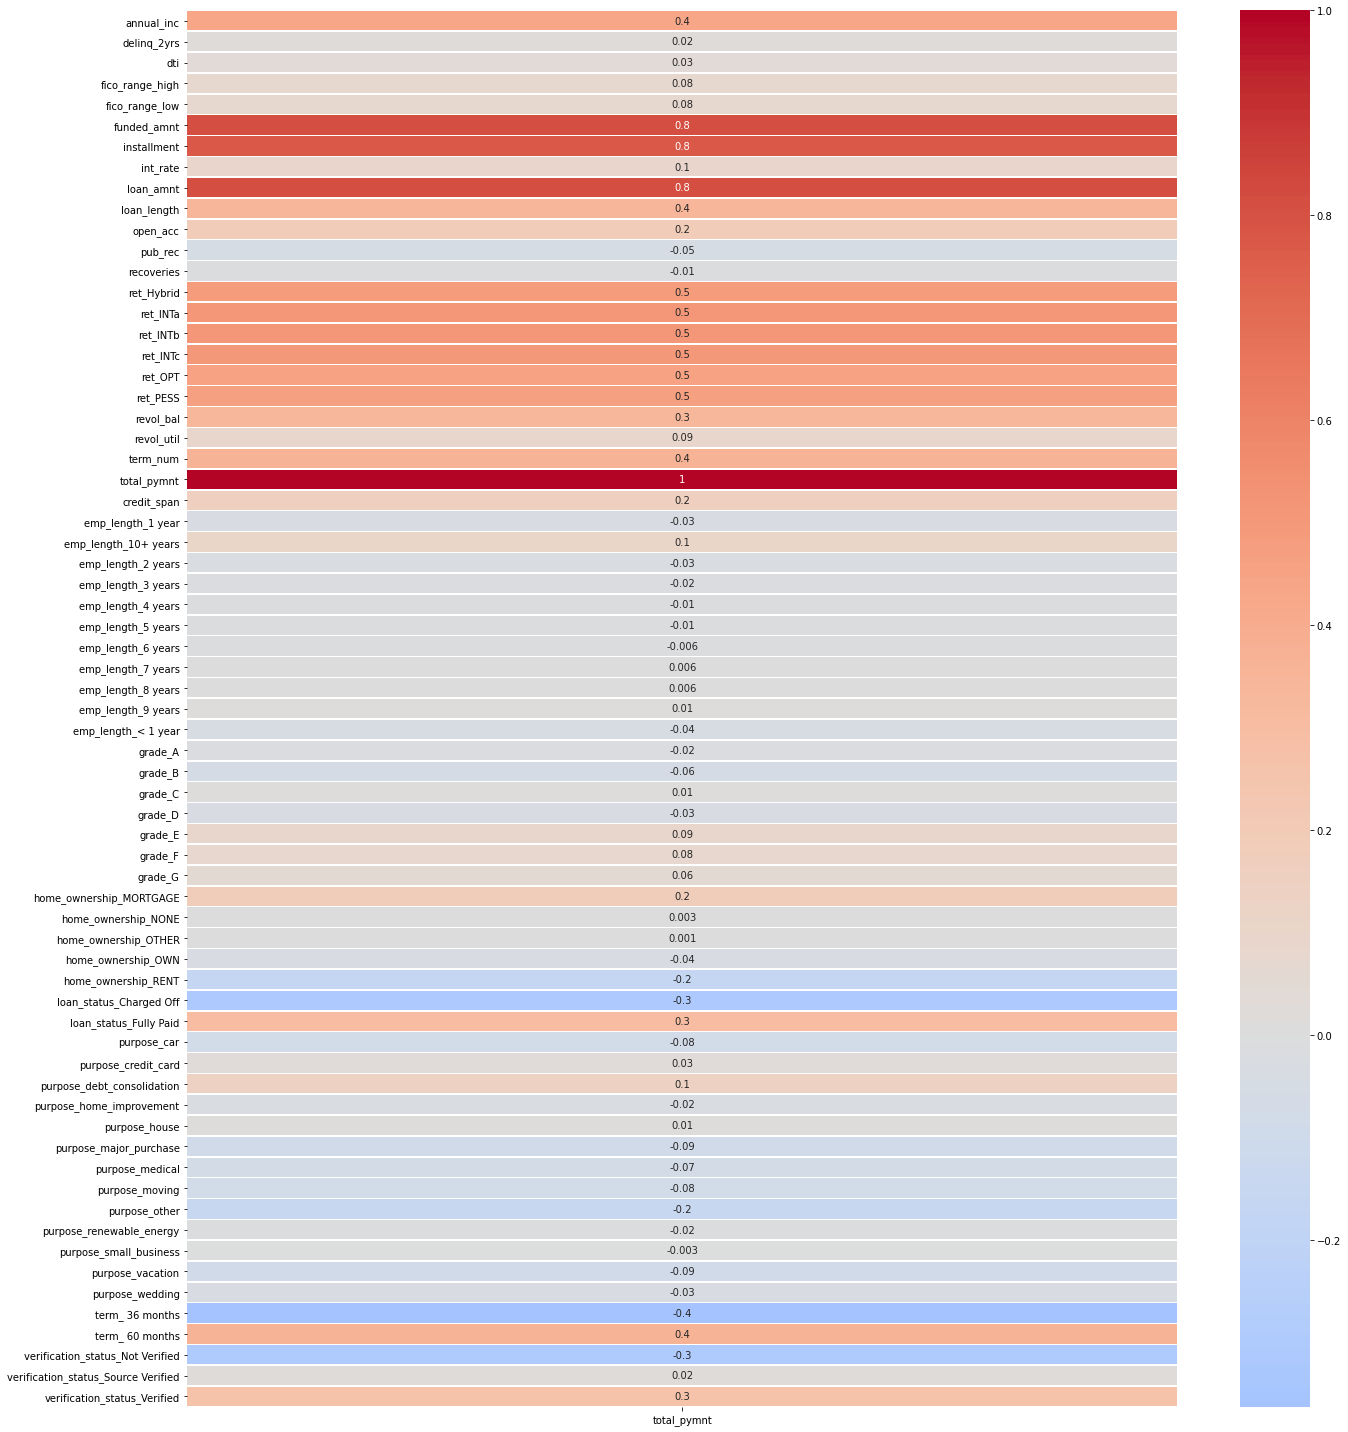

In [ ]:
correl_corr = correl_df_cat.corr()
fig, axs = plt.subplots(1, 1,figsize = (20, 20), tight_layout=True)
sns.heatmap(correl_corr[['total_pymnt']], center= 0, annot = True, fmt = '.1g', cmap= 'coolwarm', linewidths=.5, ax = axs)

## Step 6- K-means analysis

#### This is for you to add to this notebook.
1. Remember to re-scale each dimension so that they have the same magnitude, whenever you use. The easiest way to do this is to standardize the numerical variables to have mean 0 and variance 1. Some interesting columns for this cluster analysis may be fico high, fico low,  int_rate, annual_inc, loan_amount, emp_length. You will have to convert the last field emp_length into a numerical variable.
2. Try a K-means analysis for a small K (say 4) and compare the cluster membership with the grade of the loans in the cluster to see if you can recover the grading given by Lending Club using your analysis.
3. When you have a good set of clusters, explain how the clusters are different frome ach other by examining the centroid values in each coordinate, and plotting the centroids in a parallel coordinates plot so you can visually tell how the clusters are different from each other on some key dimensions.
4. Run an analysis to examine what a good number of clusters could be by plotting the "inertia" (sum of within cluster distances to centroid) agains varius values of number of clusters to create a scree plot; See if there are any natural points in this plot where the reduction in the inter-cluster distances trails off.

Reference - Much of the K-Means code was adapted from this blog: https://realpython.com/k-means-clustering-python/

### Data preproccessing

Before the k-means algorithm is applied, we will perform the following steps:

1. Verify that transformed continuous variable from step 1 are appropriate for K means (as normally distributed as possible, with outliers handled appropriately).
2. Transform discrete variables for modeling into numerical variables.

In [ ]:
# Datatype column definitions from Week 1
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Borrower characteristics - We want to limit KMeans to characteristics known at the time grades are determined.
borrower_chars = ['annual_inc', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length',
                  'fico_range_high', 'fico_range_low', 'home_ownership', 'loan_amnt',
                  'open_acc', 'pub_rec', 'purpose', 'revol_bal', 'revol_util',
                  'verification_status', 'term', 'funded_amnt', 'issue_d']

In [ ]:
# Make a copy of our final_data DF for clustering
cluster_data = final_data.copy()

In [ ]:
final_data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util',
       'total_pymnt', 'last_pymnt_d', 'recoveries', 'loan_amnt_orig',
       'funded_amnt_orig', 'term_orig', 'int_rate_orig', 'installment_orig',
       'grade_orig', 'emp_length_orig', 'home_ownership_orig',
       'annual_inc_orig', 'verification_status_orig', 'issue_d_orig',
       'loan_status_orig', 'purpose_orig', 'dti_orig', 'delinq_2yrs_orig',
       'earliest_cr_line_orig', 'open_acc_orig', 'pub_rec_orig',
       'fico_range_high_orig', 'fico_range_low_orig', 'revol_bal_orig',
       'revol_util_orig', 'total_pymnt_orig', 'last_pymnt_d_orig',
       'recoveries_orig', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT',
       'ret_INTa'

#### 1. Transform continuous variables



Note: The following columns have already been log-transformed in Week 1: ['annual_inc','revol_bal','open_acc', 'total_pymnt']

We will log transform several more in prepraration for clustering.

In [ ]:
## Only use variables that are known at loan grade decision time.
print(set(float_cols + perc_cols) & set(borrower_chars))

{'pub_rec', 'fico_range_low', 'annual_inc', 'revol_bal', 'delinq_2yrs', 'dti', 'funded_amnt', 'fico_range_high', 'loan_amnt', 'revol_util', 'open_acc'}


In [ ]:
# Log transform the following columns in preparation for k means
cols_to_log = ['loan_amnt','funded_amnt','pub_rec','delinq_2yrs','fico_range_high','fico_range_low']
for c in cols_to_log:
  cluster_data[c] = np.log10(cluster_data[c] + 1)

In [ ]:
## CHECK - Do our variables look nicely distributed?
## Note - comment out once variable transformations are complete.

# for col in list(set(continuous_features) & set(borrower_chars)):
#   #Draw the histogram
#   fig = px.histogram(cluster_data, x=col)
#   fig.show()

#### 2. Discrete variables

We will explore discrete variables that may be used for clustering.

In [ ]:
## Only use variables that are known at loan grade decision time.
print(set(cat_cols) & set(borrower_chars))

{'term', 'home_ownership', 'purpose', 'emp_length', 'verification_status'}


In [ ]:
## Emp Length
## Drop records with no employment length
## Convert to numeric value

n_rows = len(cluster_data)
cluster_data.dropna(subset = ['emp_length'] ,inplace=True)
print("Removed " + str(n_rows - len(cluster_data)) + " rows")

def emp_length_transformer(x):
  if (x == "< 1 year"): ## Encoding <1 year as 0
    return 0
  matches = re.findall(r'\d+', x)
  return int(matches[0])

emp_length_transformer_v = np.vectorize(emp_length_transformer)

cluster_data['emp_length'] = emp_length_transformer_v(cluster_data['emp_length'])

Removed 7875 rows


In [ ]:
## Verification status
## NOTE - Addition of verification_status did not further separate clusters.
## This column will NOT be included in the final clustering set.

# verification_status_dummies = pd.get_dummies(cluster_data['verification_status'])
# verification_status_dummies.columns = ['verification_status_'+c for c in verification_status_dummies.columns]
# cluster_data = pd.concat([cluster_data,verification_status_dummies],axis=1)

In [ ]:
## Final step before clustering - visualize how many data points are in each cluster
grp = cluster_data.groupby('grade').count().reset_index()
fig = px.bar(grp, x="grade", y="id", barmode="group")
fig.show()

In [ ]:
## Note - combine E, F, and G grades into one group, as they are very small
# This helped with simplifying cluster results when choosing features/scaling
cluster_data['grade_consolidated'] = cluster_data.apply(lambda row: "EFG" if row['grade'] in ['E','F','G'] else row['grade'],axis=1)

#### Choose columns and standardize data

Per the assignment notes, we started by exploring the following columns for this cluster analysis: fico high, fico low, int_rate, annual_inc, loan_amount, emp_length.

Because fico_high and fico_low are highly correlated, we only included one in the final cluster analysis so as not to inflate the importance of the fico score. The intertia values when choosing fico high or fico low were virtually identical. We chose to include fico high because it is easier to visualize separation in this variable later.

In [ ]:
## Explore two scaling options - standard scaling and minmax scaling.
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [ ]:
cluster_cols = [
                # "fico_range_high", 
                "fico_range_low", 
                "int_rate", "annual_inc", "loan_amnt","emp_length"]

In [ ]:
## Final visualization of cluster cols - comment out when variables have been selected and vetted

# for col in cluster_cols:
#   #Draw the histogram
#   fig = px.histogram(cluster_data, x=col)
#   fig.show()
#   # plt.hist(final_data[col],20)
#   # plt.title(col)
#   # plt.show()

In [ ]:
## Apply standard scaling to cluster variables
x = cluster_data[cluster_cols].values
x_scaled = standard_scaler.fit_transform(x)

### Evaluate K-Means on small number of clusters

Run the KMeans algorithm on the scaled data. We explored clusters of sizes 3-6, and ultimately saw 4 clusters give the nicest separation by Grade.

In [ ]:
## Run k means
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

n_clusters = 4
cluster_order = list(range(n_clusters)) # Used for visualization later

kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(x_scaled)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=4,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

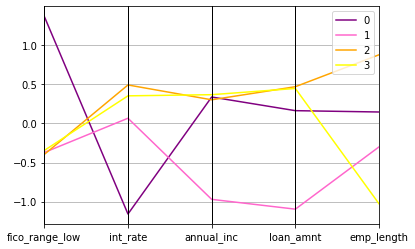

In [ ]:
## Parallel coordinate plot
## Use this plot to determine if there is good separation between clusters
## Here we can see that clusters 0 and 2 are fairly well separated.
## Clusters 1 and 3 share many of the same characteristics, except for employment length.

centers = kmeans.cluster_centers_
centers_df = pd.DataFrame((centers), columns = cluster_cols)
centers_df['label'] = range(n_clusters)

pd.plotting.parallel_coordinates(
    centers_df, 'label',
    color=['purple','#ff66cc','orange','#FFFF00']
)

In [ ]:
## Crosstab of kmeans_label vs loan grade by record count
# This shows how many records by grade are assigned to each Kmeans cluster
cluster_data['kmeans_label'] = kmeans.labels_
pd.crosstab(cluster_data['kmeans_label'],cluster_data['grade'])

grade,A,B,C,D,E,F,G
kmeans_label,,,,,,,
0,23084,13828,1522,101,14,3,0
1,2436,18714,14303,8038,1877,539,46
2,655,14594,19636,11213,6002,3067,640
3,1157,12717,12380,7243,3855,1907,400


In [ ]:
## Crosstab of kmeans labels vs actual grade, showing % of each grade in each cluster
# This view makes it easy to see if a grade is predominantly assigned to a particular cluster
pd.crosstab(cluster_data['kmeans_label'],cluster_data['grade']).apply(lambda r: r/r.sum(), axis=0)

grade,A,B,C,D,E,F,G
kmeans_label,,,,,,,
0,0.844578,0.231033,0.031814,0.003798,0.001192,0.000544,0.000000
1,0.089126,0.312666,0.298970,0.302237,0.159772,0.097716,0.042357
2,0.023965,0.243831,0.410443,0.421621,0.510895,0.556019,0.589319
3,0.042331,0.212471,0.258774,0.272344,0.328141,0.345722,0.368324


In [ ]:
## Finally, visualize the above percentage crosstab as a bar chart

### Note - the numbers of the clusters below may change with each re-run!!! 
## Cluster 0 contains the majority of the D-G grade loans
## Cluster 2 contains the majority of the A grade loans
## Cluster 1 contains the majority of the C grade loans, as well as a high share of B and D grade loans
## Cluster 3 contains the majority of the B grade loans, as well as a high share of the C grade loans

## Note - all else equal, employment length can serve as a boost in Grade.

cluster_percent = pd.crosstab(cluster_data['kmeans_label'],cluster_data['grade']).apply(lambda r: r/r.sum(), axis=0)
cluster_percent = cluster_percent.stack().reset_index()
cluster_percent.columns = ['kmeans_label','grade','percent']
cluster_percent.head()
fig = px.bar(cluster_percent, x="grade", y="percent", barmode="group",
             facet_col="kmeans_label", color="kmeans_label",
             category_orders={"kmeans_label": cluster_order})
fig.show()

In [ ]:
## Visualize how cluster variables (untransformed) differ between clusters
## Use this information to make inferences about which variables drive Grade decisions

for c in cluster_cols:
  if c in continuous_features:
    c = c+"_orig"
    fig = px.box(cluster_data, y=c, facet_col="kmeans_label",color="kmeans_label",category_orders={"kmeans_label": cluster_order})
    fig.show()

    fig = px.histogram(cluster_data, x=c, facet_col="kmeans_label", color="kmeans_label",category_orders={"kmeans_label": cluster_order})
    fig.show()
  if c == "emp_length":
    emp_length_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]
    c = c+"_orig"
    grouped_data = cluster_data.groupby(['kmeans_label','emp_length']).count().reset_index()
    fig = px.bar(grouped_data, x="emp_length", y="id", barmode="group",
             facet_col="kmeans_label", color="kmeans_label",
             category_orders={"kmeans_label": cluster_order,"emp_length":emp_length_order})
    fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Evaluate K-Means on a range of cluster sizes

In this section, we plot the inertia over of a range of clusters in a scree plot. The "elbow" of the scree plot is the point where the reduction in inter-cluster distances trails off. We will re-run clustering at this point to look at the separation by grade again.

*Note: This takes a long time to run!*

In [ ]:
## Note - This cell takes a long time to run!!!
min_clusters = 1
max_clusters = 14

# A list holds the SSE values for each k
sse = []
for k in range(min_clusters, max_clusters + 1):
    print("Cluster "+str(k))
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_scaled)
    sse.append(kmeans.inertia_)

Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
Cluster 7
Cluster 8
Cluster 9
Cluster 10
Cluster 11
Cluster 12
Cluster 13
Cluster 14


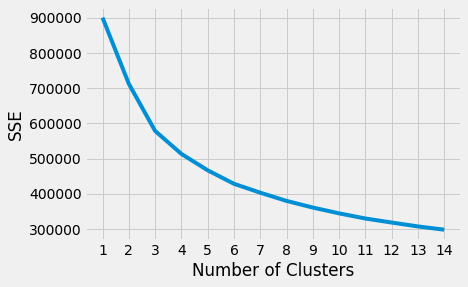

In [ ]:
## Scree plot showing inertia by number of clusters
plt.style.use("fivethirtyeight")
plt.plot(range(min_clusters, max_clusters + 1), sse)
plt.xticks(range(min_clusters, max_clusters+ 1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
## The KneeLocator class locates the elbow of the scree plot for us
kl = KneeLocator(
    range(min_clusters, max_clusters + 1), sse, curve="convex", direction="decreasing"
)

final_num_clusters = kl.elbow
print("Elbow:", final_num_clusters)

Elbow: 5


In [ ]:
# Re-run K Means with number of clusters equal to the elbow point
kmeans = KMeans(n_clusters=final_num_clusters, **kmeans_kwargs)
kmeans.fit(x_scaled)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

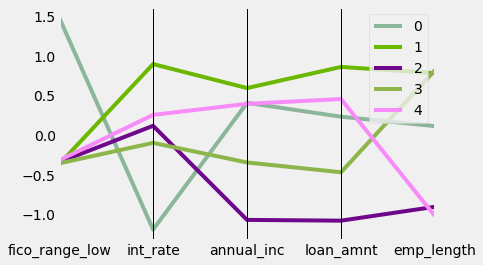

In [ ]:
## Show parallel lines plot
# Note that clusters have very good separation here
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame((centers), columns = cluster_cols)
centers_df['label'] = range(final_num_clusters)
pd.plotting.parallel_coordinates(
    centers_df, 'label'
)

In [ ]:
## Show grade crosstab by record count
cluster_data['kmeans_label'] = kmeans.labels_
pd.crosstab(cluster_data['grade'],cluster_data['kmeans_label'])

kmeans_label,0,1,2,3,4
grade,,,,,
A,21562,115,2086,2216,1353
B,10878,4034,11709,20763,12469
C,1329,10896,9843,13736,12037
D,85,8780,6330,5115,6285
E,15,6501,1650,730,2852
F,2,3659,508,131,1216
G,0,801,47,8,230


In [ ]:
## Show grade crosstab by percent
pd.crosstab(cluster_data['kmeans_label'],cluster_data['grade']).apply(lambda r: r/r.sum(), axis=0)

grade,A,B,C,D,E,F,G
kmeans_label,,,,,,,
0,0.788892,0.181745,0.027780,0.003196,0.001277,0.000363,0.000000
1,0.004208,0.067398,0.227754,0.330137,0.553371,0.663343,0.737569
2,0.076321,0.195629,0.205744,0.238015,0.140449,0.092096,0.043278
3,0.081077,0.346900,0.287118,0.192329,0.062138,0.023749,0.007366
4,0.049502,0.208327,0.251604,0.236323,0.242765,0.220450,0.211786


Clustering final thoughts: Even though our clusters look more separated on the parallel coordinate plot at the elbow point vs the parallel lines plot with four clusters, we don't see a lift in terms of grade separation at the elbow point. That is, the extra clusters in the above iteration do not help us to further separate by grade.

This is a nice reminder that K-means does not cluster with a particular target variable in mind. It takes work and many iterations of feature variables to produce a clustering that aligns with a desired target variable.

## Step 7 - PCA
Run a principal component analysis

#### This is for you to add to this notebook.
1. You could run the PCA for the same numerical variables that you analyzed under K-Means above. Remember you have already standardized them.
2. Examine the component loadings for the diferent variables in first few principal components. Similarly, exaine the top features for each PC in terms of loadings.
3. Add a biplot of how key variables are represented in the first two PCs e.g.

In [ ]:
# Make a copy of our final_data DF for clustering
## Note - this assignment will overwrite K-Means clustering results
cluster_data = final_data.copy()

In [ ]:
# Log Transformation for 'annual_inc','revol_bal','open_acc', 'total_pymnt'
Log_Columns = ['loan_amnt','funded_amnt','pub_rec','delinq_2yrs','fico_range_high']

for i in Log_Columns:
    
    cluster_data[i] = np.log10(cluster_data[i]+1)

In [ ]:
## Emp Length
## Drop records with no employment length
## Convert to numeric value

n_rows = len(cluster_data)
cluster_data.dropna(subset = ['emp_length'] ,inplace=True)
print("Removed " + str(n_rows - len(cluster_data)) + " rows")

def emp_length_transformer(x):
    if (x == None) or (x == "< 1 year"):
        return 0
    matches = re.findall(r'\d+', x)
    return int(matches[0])

emp_length_transformer_v = np.vectorize(emp_length_transformer)

cluster_data['emp_length'] = emp_length_transformer_v(cluster_data['emp_length'])

Removed 7875 rows


In [ ]:
# Select columns for PCA (they were the same columns that were used in K menas)

pca_cols = ["fico_range_high", "int_rate", "annual_inc", "loan_amnt","emp_length"]

In [ ]:
# Separating out the features
x = cluster_data.loc[:, pca_cols].values

In [ ]:
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
pcamodel = PCA()
pca = pcamodel.fit_transform(x)
pca.shape

(179971, 5)

#### A bar polt that shows the percentage of variance explained by each of the selected components. 

No handles with labels found to put in legend.


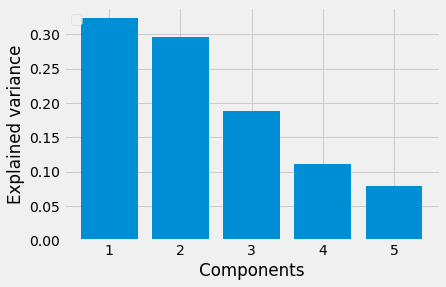

In [ ]:
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.legend(loc='upper left')

#### Line graph to show cumulative explained variance for each principle components

Text(0, 0.5, 'cumulative explained variance')

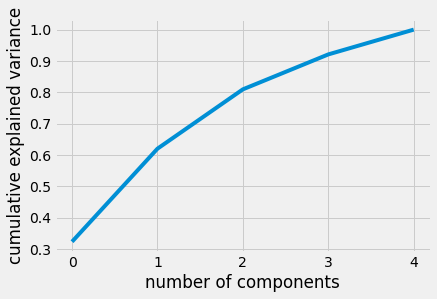

In [ ]:
plt.plot(np.cumsum(pcamodel.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

#### Loading matrix to show weights of each component

In [ ]:
loadings = pd.DataFrame(pcamodel.components_.T, columns=["PCA"+str(x) for x in range(1,6)], index=pca_cols)
loadings

,PCA1,PCA2,PCA3,PCA4,PCA5
fico_range_high,0.614030,0.340186,0.019634,-0.326651,0.632577
int_rate,-0.509541,-0.506453,0.061847,-0.192769,0.665499
annual_inc,0.456824,-0.478664,0.189792,0.704694,0.171985
loan_amnt,0.359456,-0.573923,0.234934,-0.599030,-0.356893
emp_length,0.159493,-0.263197,-0.951091,-0.026626,0.002497


#### Visualizing the loading matrix using heatmap

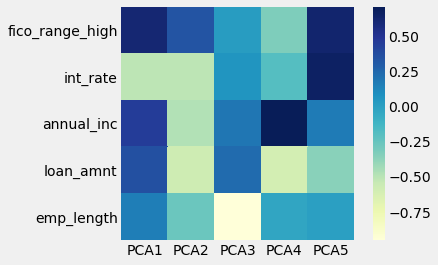

In [ ]:
import seaborn as sns 

ax = sns.heatmap(pcamodel.components_.T,
                 cmap='YlGnBu',
                 yticklabels=list(pca_cols),
                 xticklabels=["PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")

#### Scatterplot for PC1 and PC2

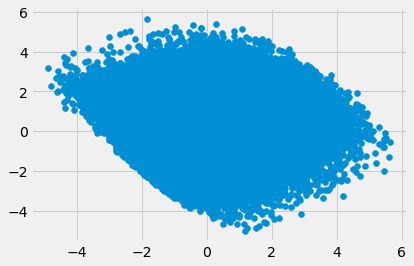

In [ ]:
plt.scatter(pca[:, 0], pca[:, 1])

#### Biplot for PC1 and PC2

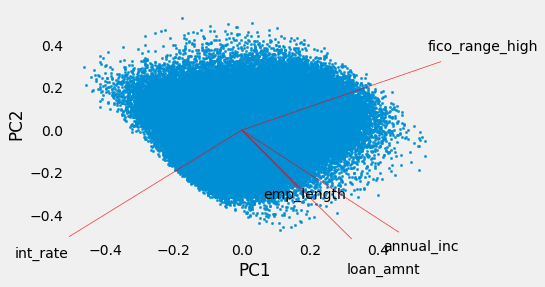

In [ ]:
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

biplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(pca_cols))
plt.show()

### Step 8 - Save data including returns information in a pickle for further analysis

In [ ]:
## Remove the total_pymnt from the list of continuous features;
## this variable is highly predictive of the outcome
## but is not known at the time the loan is issued
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]

In [ ]:
# Define the output path for the full pickle with returns info
#full_pickle_file = "/".join( ['.'] + ["PickleData"] + ["201213ret_data.pickle"] )
full_pickle_file = pickle_data = path_to_data+"201213_ret.pickle" #change the name of the pickle file here 

pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(full_pickle_file, "wb") )